In [18]:
import numpy as np
from scipy.optimize import least_squares

import matplotlib.pyplot as plt

import sys
sys.path.append('../../m1epma')
sys.path.append('m1epma')
import physics
import experiment
from physics import keV, nano
import optimization
import m1model
import pickle


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.rc('axes', titlesize='small')     # fontsize of the axes title
plt.rc('axes', labelsize='small')    # fontsize of the x and y labels
plt.rc('legend', fontsize='small')    # legend fontsize


In [10]:
elements = [physics.Copper(), physics.Manganese()]
x_rays = [physics.XRay(e, 1.) for e in elements]

material = physics.Material(
    n_x = 10,
    n_y = 10,
    hat_n_x = 80,
    hat_n_y = 60,
    dim_x = [0., 1000.*nano],
    dim_y = [-800.*nano, 0.]
)

detector = physics.Detector(
    x=500.*nano,
    y=50.*nano,
    material = material)

electron_beams = [
    physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[450.*nano, -100.*nano],
        beam_energy_keV=12.,
        energy_variation_keV=0.1
    ),
    physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[450.*nano, -100.*nano],
        beam_energy_keV=11.,
        energy_variation_keV=0.1
    ),
    physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[450.*nano, -100.*nano],
        beam_energy_keV=10.,
        energy_variation_keV=0.1
    ),
    physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[550.*nano, -100.*nano],
        beam_energy_keV=12.,
        energy_variation_keV=0.1
    ),
    physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[550.*nano, -100.*nano],
        beam_energy_keV=11.,
        energy_variation_keV=0.1
    ),
    physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[550.*nano, -100.*nano],
        beam_energy_keV=10.,
        energy_variation_keV=0.1
    )
]

experiments = [
    experiment.Experiment(
        material=material,
        detector=detector,
        electron_beam=electron_beam,
        elements=elements,
        x_ray_transitions=x_rays,
        epsilon_initial_keV=13.,
        epsilon_cutoff_keV=5.,
        n_epsilon=100
    )
    for electron_beam in electron_beams]
n_x_ray_transitions = experiments[0].n_x_ray_transitions

# generate the measured k-ratios
true_parameters = np.array(
    [
        [0.78, 0.72, 0.71, 0.65, 0.2 , 0.09, 0.97, 0.17, 0.62, 0.85],
        [0.03, 0.16, 0.78, 0.28, 0.23, 0.45, 0.09, 0.06, 0.97, 0.67],
        [0.6 , 0.49, 0.09, 0.48, 0.07, 0.27, 0.76, 0.95, 0.03, 0.09],
        [0.96, 0.64, 0.4 , 0.26, 0.8 , 0.93, 0.19, 0.9 , 0.87, 0.08],
        [0.16, 0.9 , 0.5 , 0.83, 0.62, 0.41, 0.19, 0.32, 0.61, 0.36],
        [0.62, 0.75, 0.47, 0.61, 0.68, 0.65, 0.98, 0.35, 0.14, 0.94],
        [0.72, 0.78, 0.96, 0.44, 0.03, 0.66, 0.16, 0.56, 0.72, 0.21],
        [0.  , 0.38, 0.86, 0.55, 0.21, 0.66, 0.49, 0.44, 0.66, 0.11],
        [0.81, 0.19, 0.58, 0.8 , 0.63, 0.77, 0.82, 0.32, 0.97, 0.64],
        [0.48, 0.05, 0.16, 0.56, 0.49, 0.46, 0.58, 0.04, 0.84, 1.  ]
    ]
).reshape((material.n_x, material.n_y, 1))
n_parameters = material.n_x*material.n_y

variable_parameters = [(4, -1, 0), (5, -1, 0), (4, -2, 0), (5, -2, 0)]


n_k_ratios = sum([e.n_x_ray_transitions for e in experiments])

In [3]:
for e in experiments:
    e.update_std_intensities()

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution


In [4]:
true_k_ratios = np.zeros(n_k_ratios)
for i, e in enumerate(experiments):
    k_ratios_e = experiment.k_ratios(e, true_parameters)
    true_k_ratios[i*n_x_ray_transitions:(i+1)*n_x_ray_transitions] = k_ratios_e
print(true_k_ratios)
def f(parameters):
    k_ratios = np.zeros(n_k_ratios)
    for i, e in enumerate(experiments):
        k_ratios_e = experiment.k_ratios(e, parameters)
        k_ratios[i*n_x_ray_transitions:(i+1)*n_x_ray_transitions] = k_ratios_e
    return k_ratios - true_k_ratios

def F(x):
    return 1./2. * np.linalg.norm(f(x))

N = 30
objective1 = np.zeros((N, N))
for i, p1 in enumerate(np.linspace(0, 1, N)):
    for j, p2 in enumerate(np.linspace(0, 1, N)):
        parame = np.copy(true_parameters)
        parame[4, -2] = p1
        parame[5, -2] = p2
        objective1[i, j] = F(parame)
        print("{}, {}".format(i, j))
#with open('objective1.pkl', 'wb') as writefile:
#    pickle.dump(objective1, writefile)   

objective2 = np.zeros((N, N))
for i, p1 in enumerate(np.linspace(0, 1, N)):
    for j, p2 in enumerate(np.linspace(0, 1, N)):
        parame = np.copy(true_parameters)
        parame[4, -1] = p1
        parame[4, -2] = p2
        objective2[i, j] = F(parame)
        print("{}, {}".format(i, j))
#with open('objective2.pkl', 'wb') as writefile:
#    pickle.dump(objective2, writefile) 


calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
[0.44669329 0.52852058 0.42210303 0.53968342 0.38590545 0.55434584
 0.64448123 0.40953589 0.72338605 0.38137484 0.81902006 0.33524652]
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculati

1, 13
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 14
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 18
calculating forward solution
calculating forward solution
calculating forward solution
calcula

calculating forward solution
calculating forward solution
2, 29
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 4
calculating forward solution
calculating 

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

6, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
7, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 21
calculating forward solution
calcula

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forwar

10, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
10, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
10, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
10, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
10, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
10, 22
calculating forward solution
calculating forward solution
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
13, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
13, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
13, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
13, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
13, 22
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
13, 23
calculating forward solution
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 8
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
16, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
16, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
16, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
16, 22
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
16, 23
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
16, 24
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 8
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 9
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
19, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
19, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
19, 22
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
19, 23
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
19, 24
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
19, 25
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 8
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 9
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 10
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating 

calculating forward solution
calculating forward solution
22, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
22, 22
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
22, 23
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
22, 24
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
22, 25
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
22, 26
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 8
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 9
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 10
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 11
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating

calculating forward solution
calculating forward solution
25, 22
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
25, 23
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
25, 24
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
25, 25
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
25, 26
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
25, 27
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 8
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 9
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 10
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 11
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 12
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculatin

calculating forward solution
calculating forward solution
28, 23
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
28, 24
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
28, 25
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
28, 26
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
28, 27
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
28, 28
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 9
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 10
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 11
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 12
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
0, 13
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating fo

calculating forward solution
1, 24
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 25
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 26
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 27
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 28
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
1, 29
calculating forward solution
calculating forward solution
calcula

calculating forward solution
calculating forward solution
calculating forward solution
3, 10
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 11
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 12
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 13
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 14
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
3, 15
calcula

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 26
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 27
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 28
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
4, 29
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
5, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating fo

calculating forward solution
6, 11
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 12
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 13
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 14
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
6, 16
calculating forward solution
calculating forward solution
calcula

calculating forward solution
calculating forward solution
calculating forward solution
7, 27
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 28
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
7, 29
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
8, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
8, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
8, 2
calculatin

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 13
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 14
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
9, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
10, 28
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
10, 29
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
11, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
11, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
11, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
11, 3
calculating forward solution
calcu

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 14
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
12, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculat

calculating forward solution
calculating forward solution
calculating forward solution
13, 29
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
14, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
14, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
14, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
14, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
14, 4
calcul

15, 14
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
15, 19
calculating forward solution
calculating forward solution
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
17, 0
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
17, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
17, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
17, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
17, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
18, 15
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
18, 20
calculating forward solution
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
20, 1
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
20, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
20, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
20, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
20, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
21, 16
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
21, 21
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
23, 2
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
23, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
23, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
23, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
23, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
24, 17
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
24, 22
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
26, 3
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
26, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
26, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
26, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
26, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

calculating forward solution
calculating forward solution
27, 18
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 19
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 20
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 21
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 22
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
27, 23
calculating forward solution
c

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
29, 4
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
29, 5
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
29, 6
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
29, 7
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
29, 8
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating f

In [5]:
with open('objective2.pkl', 'wb') as writefile:
    pickle.dump(objective2, writefile) 
with open('objective1.pkl', 'wb') as writefile:
    pickle.dump(objective1, writefile) 

In [ ]:
with open('objective1.pkl', 'rb') as readfile1:
    objective1 = pickle.load(readfile1)
with open('objective2.pkl', 'rb') as readfile2:
    objective2 = pickle.load(readfile2)

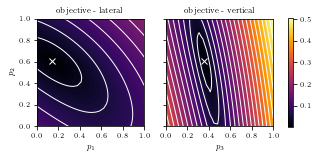

In [20]:

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5.3, 2))

p = np.linspace(0, 1, objective1.shape[0])
p1, p2 = np.meshgrid(p, p)
vmin = min(objective1.min(), objective2.min())
vmax = max(objective1.max(), objective2.max())
im = ax[0].contourf(p1, p2, objective1, cmap="inferno", levels=np.linspace(vmin, vmax, 100))
ax[0].contour(p1, p2, objective1, colors='white', linewidths=1, levels=np.linspace(vmin, vmax, 20))
# ax[0].axis('equal')
ax[0].plot(true_parameters[variable_parameters[3]], true_parameters[variable_parameters[2]], 'x', color='white', label='true minimum')
ax[0].title.set_text('objective - lateral')
ax[0].set_ylabel("$p_2$")
ax[0].set_xlabel("$p_1$")
ax[0].set_aspect("equal", "box")
im = ax[1].contourf(p2, p1, objective2, cmap="inferno", levels=np.linspace(vmin, vmax, 100))
ax[1].contour(p2, p1, objective2, colors='white', linewidths=1, levels=np.linspace(vmin, vmax, 20))
# ax[1].axis('equal')
ax[1].plot(true_parameters[variable_parameters[0]], true_parameters[variable_parameters[2]], 'x', color='white', label='true minimum')
ax[1].title.set_text('objective - vertical')
ax[1].set_xlabel("$p_3$")
ax[1].set_xlim((0., 1.))
ax[1].set_aspect("equal", "box")
# ax[1].legend()
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.set_ticks(np.round(np.linspace(0, vmax, 6), 2))
# cbar.set_ticklabels(np.round(np.linspace(0, vmax, 5), 2))
plt.savefig("objective.pdf", bbox_inches='tight')
plt.show()